## Gaussian Process (GP) Regression from scratch (1D)

Autor: Ole Uphaus

In diesem Jupyter Notebook werde ich **Gauß-Prozesse** nutzen, um ein **Regeressionsproblem** zu lösen. Dabei werde ich nicht auf integrierte Pakete zurückgreifen, sondern alle mathematischen Grundlagen selber implementieren.

In [103]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt

### 1. Trainings- und Testdaten erzeugen

In [104]:
def gen_base_points(n, x_min, x_max):
    """
    Generate approximately evenly spaced base points using 1D Latin Hypercube Sampling (LHS).

    This method divides the interval [x_min, x_max] into n segments of equal width
    and samples one random point within each segment.

    Parameters
    ----------
    n : int
        Number of points to generate.
    x_min : float
        Lower bound of the interval.
    x_max : float
        Upper bound of the interval.

    Returns
    -------
    points : (n,) ndarray
        Array of approximately evenly spaced base points in the interval [x_min, x_max].
    """

    random_segment_points = (np.arange(n) + np.random.random(n)) / n
    x = x_min + (x_max - x_min) * random_segment_points

    return np.sort(x)

def gen_uniform_points(n, x_min, x_max):
    """
    Generate n uniformly distributed random points in a given interval.

    Parameters
    ----------
    n : int
        Number of points to generate.
    x_min : float
        Lower bound of the interval.
    x_max : float
        Upper bound of the interval.

    Returns
    -------
    points : (n,) ndarray
        Array of uniformly distributed random points in [x_min, x_max].
    """

    return np.random.uniform(x_min, x_max, n)

def f_true(x):
    """
    True function to generate target values.

    Parameters
    ----------
    x : (n,) ndarray
        Input points.

    Returns
    -------
    y : (n,) ndarray
        Target values corresponding to input points.
    """
    return 0.5 * np.sin(x) + 0.5 * np.cos(0.7*x + 0.5)

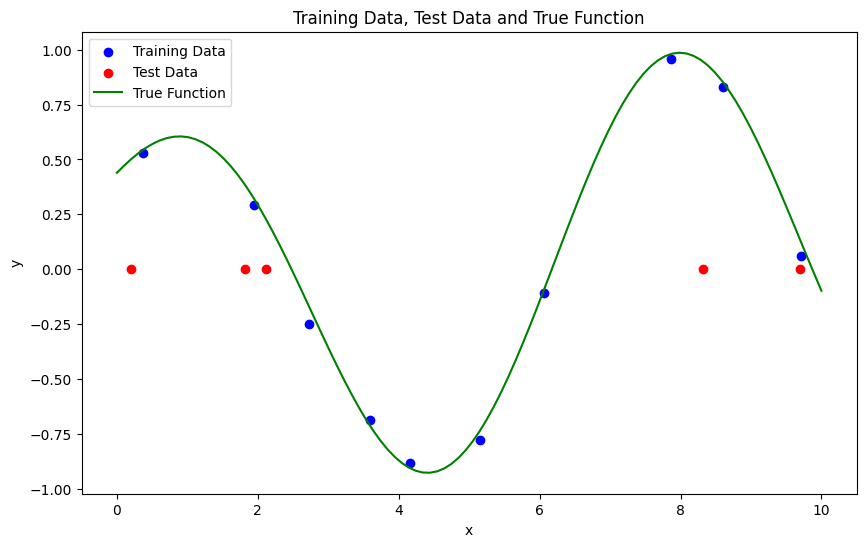

In [105]:
np.random.seed(42)

# Generate training and test data
n_train = 10
n_test = 5
x_min, x_max = 0, 10
sigma_noise = 0.03


X_train = gen_base_points(n_train, x_min, x_max)
X_test = gen_uniform_points(n_test, x_min, x_max)
Y_train = f_true(X_train) + sigma_noise * np.random.randn(n_train) # Random normal distributed noise

# Plot training data
plt.figure(figsize=(10, 6))
plt.scatter(X_train, Y_train, color='blue', label='Training Data')
plt.scatter(X_test, np.zeros_like(X_test), color='red', label='Test Data')
plt.plot(np.linspace(x_min, x_max, 100), f_true(np.linspace(x_min, x_max, 100)), color='green', label='True Function')
plt.title('Training Data, Test Data and True Function')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [106]:
# Shapes
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)

X_train shape: (10,)
Y_train shape: (10,)


### 2. Kernel festlegen und Kovarianzmatrizen berechnen

Prior Distribution:  
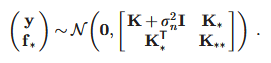

RBF Kernel:  
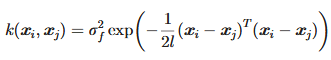

In [107]:
def pairwise_squared_dist(x1, x2):
    """
    Compute squared pairwise distances between two 1D arrays stored in a matrix.

    Parameters
    ----------
    x1, x2 : (n,), (m,) ndarray
        Input vectors.

    Returns
    -------
    dists2 : (n, m) ndarray
        Matrix of squared distances (x1[i] - x2[j])².
    """

    return (x1.reshape(-1, 1) - x2.reshape(1, -1))**2

def rbf_kernel(x1, x2, **k_params):
    """
    Compute the Radial Basis Function (RBF) kernel.

    The RBF kernel defines the covariance between two input vectors `x1` and `x2` as

        k(x1, x2) = σ² * exp( - ||x1 - x2||² / (2 * ℓ²) )

    where σ² is the signal variance and ℓ is the lengthscale parameter.

    Parameters
    ----------
    x1, x2 : (n,), (m,) ndarray
        Input vectors.
    lengthscale : float, optional
        Characteristic lengthscale ℓ controlling smoothness of the function
    variance : float, optional
        Signal variance σ² scaling the overall magnitude of the kernel

    Returns
    -------
    K : (n, m) ndarray
        Covariance matrix where `K[i, j] = k(x1[i], x2[j])`.
    """

    dists2 = pairwise_squared_dist(x1, x2)
    return k_params['variance'] * np.exp(-0.5 * dists2 / (k_params['lengthscale']**2))

In [108]:
k_params = {
    'lengthscale': 1.0,
    'variance': 1.0
}

# Calculate covariance matrices (x - training data, xs - test data)
K_xx = rbf_kernel(X_train, X_train, **k_params)
K_xxs = rbf_kernel(X_train, X_test, **k_params)
K_xsxs = rbf_kernel(X_test, X_test, **k_params)

# Print the covariance matrix shapes
print("Shape K_xx:\n", K_xx.shape)
print("Shape K_xxs:\n", K_xxs.shape)
print("Shape K_xsxs:\n", K_xsxs.shape)

Shape K_xx:
 (10, 10)
Shape K_xxs:
 (10, 5)
Shape K_xsxs:
 (5, 5)


### 3. GP Posterior berechnen (Vorhersagen für Testdaten)

Gleichungen:  
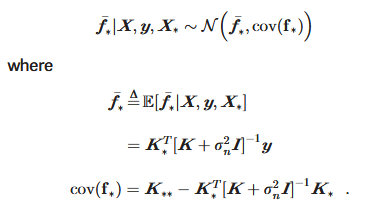

In [109]:
def gp_posterior(X_train, Y_train, X_test, kernel, sigma_noise, **k_params):
    """
    Compute the Gaussian Process (GP) posterior mean and covariance for test points.

    Parameters
    ----------
    X_train : (n_train,) ndarray
        Training input points.
    Y_train : (n_train,) ndarray
        Training target values.
    X_test : (n_test,) ndarray
        Test input points where predictions are to be made.
    kernel : callable
        Kernel function to compute covariance matrices.
    sigma_noise : float
        Standard deviation of the observation noise.

    Returns
    -------
    mu_post : (n_test,) ndarray
        Posterior mean at the test points.
    cov_post : (n_test, n_test) ndarray
        Posterior covariance matrix at the test points.
    """

    K_xx = kernel(X_train, X_train, **k_params)
    K_xxs = kernel(X_train, X_test, **k_params)
    K_xsxs = kernel(X_test, X_test, **k_params)

    # Add noise term on the diagonal
    K_xx += sigma_noise**2 * np.eye(len(X_train))  

    # Compute K_xx^-1 * Y_train = alpha -> K_xx * alpha = Y_train (solve linear system)
    alpha = np.linalg.solve(K_xx, Y_train)

    # Compute K_xx^-1 * K_xxs = beta -> K_xx * beta = K_xxs (solve linear system)
    beta = np.linalg.solve(K_xx, K_xxs) 

    # Compute posterior mean and covariance
    mu_post = K_xxs.T @ alpha
    cov_post = K_xsxs - K_xxs.T @ beta

    return mu_post, cov_post

Posterior mean shape: (5,)
Posterior covariance shape: (5, 5)


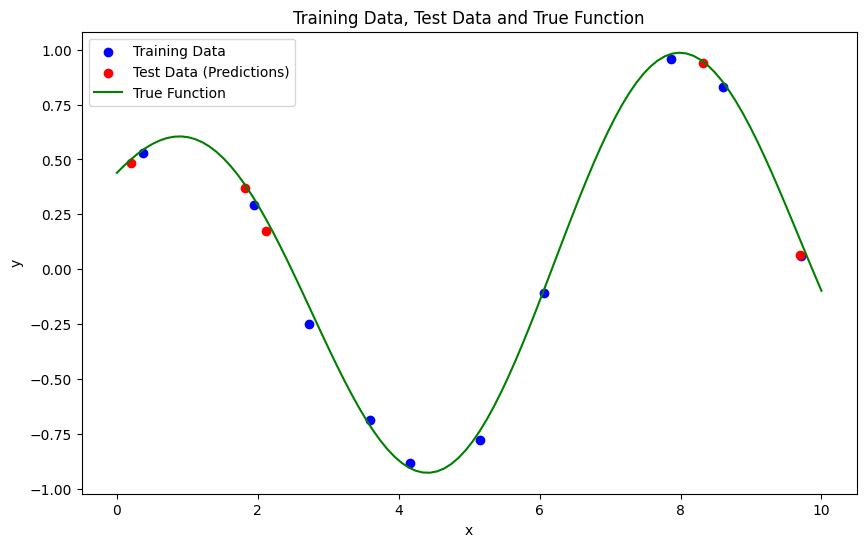

In [110]:
# Generate test predictions
mu_post, cov_post = gp_posterior(X_train, Y_train, X_test, rbf_kernel, sigma_noise, **k_params)

print("Posterior mean shape:", mu_post.shape)
print("Posterior covariance shape:", cov_post.shape)

# Plot results
plt.figure(figsize=(10, 6))
plt.scatter(X_train, Y_train, color='blue', label='Training Data')
plt.scatter(X_test, mu_post, color='red', label='Test Data (Predictions)')
plt.plot(np.linspace(x_min, x_max, 100), f_true(np.linspace(x_min, x_max, 100)), color='green', label='True Function')
plt.title('Training Data, Test Data and True Function')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

### 4. Funktion der Mittelwerte und dazugehörige Unsicherheiten visualisieren

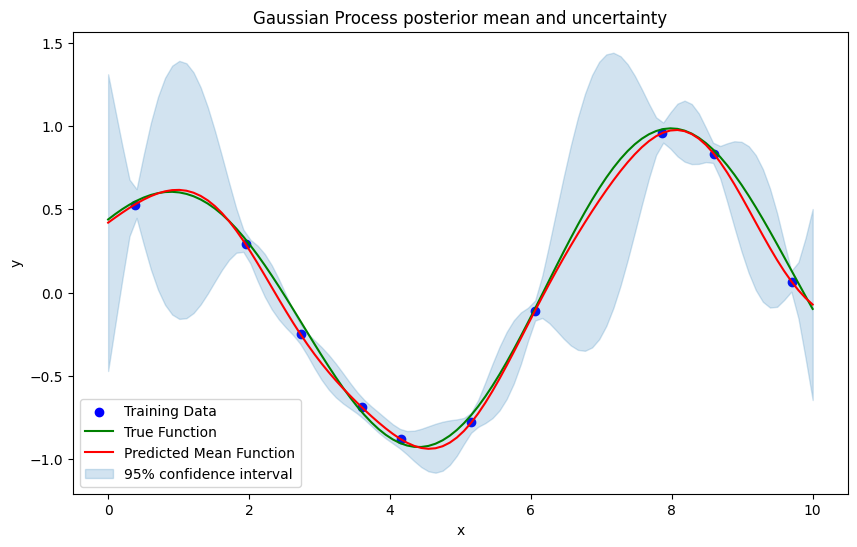

In [125]:
k_params = {
    'lengthscale': 1.0,
    'variance': 2.0
}

X_test_plot = np.linspace(x_min, x_max, 100)
mu_post_plot, cov_post_plot = gp_posterior(X_train, Y_train, X_test_plot, rbf_kernel, sigma_noise, **k_params)
std_post_plot = np.sqrt(np.diag(cov_post_plot))

# Plot results with uncertainty
plt.figure(figsize=(10, 6))
plt.scatter(X_train, Y_train, color='blue', label='Training Data')
plt.plot(np.linspace(x_min, x_max, 100), f_true(np.linspace(x_min, x_max, 100)), color='green', label='True Function')
plt.plot(X_test_plot, mu_post_plot, color='red', label='Predicted Mean Function')
plt.fill_between(X_test_plot,
                 mu_post_plot - 2*std_post_plot,
                 mu_post_plot + 2*std_post_plot,
                 color='C0', alpha=0.2, label='95% confidence interval')
plt.title('Gaussian Process posterior mean and uncertainty')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()